## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 2, SIZE = 500000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'gfci', dfs = df, testId = 'bdeu', scoreId = 'bdeu', dataType = 'discrete',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()



def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 1


models = [LogisticRegression(), 
          Perceptron(),  
          DecisionTreeClassifier(),
          LinearSVC(),
          GaussianNB(),
          BernoulliNB(),
          LinearDiscriminantAnalysis(),
          RandomForestClassifier(),
          ExtraTreesClassifier(),
          AdaBoostClassifier(),
          BaggingClassifier(),
          GradientBoostingClassifier(),
          MLPClassifier(), 
          [2048, 2048, 2048, 1024],
         ]
model_names = ['LogisticRegression()', 
          'Perceptron()',  
          'DecisionTreeClassifier()',
          'LinearSVC()',
          'GaussianNB()',
          'BernoulliNB()',
          'LinearDiscriminantAnalysis()',
          'RandomForestClassifier()',
          'ExtraTreesClassifier()', 
          'AdaBoostClassifier()',
          'BaggingClassifier()',
          'GradientBoostingClassifier()',
          'MLPClassifier()',
          'o1'
         ]






df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data()
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values


model_list = []





/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


LogisticRegression()
Perceptron()


/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


DecisionTreeClassifier()
LinearSVC()
GaussianNB()
BernoulliNB()
LinearDiscriminantAnalysis()


/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


RandomForestClassifier()
ExtraTreesClassifier()
AdaBoostClassifier()
BaggingClassifier()
GradientBoostingClassifier()
MLPClassifier()
o1
Train on 500000 samples, validate on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 808s 2ms/step - loss: 4.4799 - mean_squared_error: 4.4799 - val_loss: 4.3674 - val_mean_squared_error: 4.3674

Epoch 00001: val_loss improved from inf to 4.36740, saving model to o1
Epoch 2/20
500000/500000 [==============================] - 750s 1ms/step - loss: 4.4232 - mean_squared_error: 4.4232 - val_loss: 4.3978 - val_mean_squared_error: 4.3978

Epoch 00002: val_loss did not improve from 4.36740
Epoch 3/20
500000/500000 [==============================] - 767s 2ms/step - loss: 4.3846 - mean_squared_error: 4.3846 - val_loss: 4.3139 - val_mean_squared_error: 4.3139

Epoch 00003: val_loss improved from 4.36740 to 4.31391, saving model to o1
Epoch 4/20
500000/500000 [==============================] - 779s 2ms/step - loss: 4.3682 - mean_squar

In [5]:
#the number of times to sample 
times = 10

## the size of the test set
nb_test = 60000

violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

#metrics_dicts = []
causal_dicts = []
for m in models:
#    metrics_dicts.append(defaultdict(list))
    causal_dicts.append(defaultdict(list))



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    setAp, setAc = get_MB(get_CG(df_test, tetrad), 'g', pc)
    setA = set(tetrad.getEdges())
    #print("BIC1 = ", tetrad.getTetradGraph().toString().split('BIC')[-1])

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
        #print(mean_squared_error(y_test, model.predict(x_test)))


        setBp, setBc = get_MB(get_CG(test_df, tetrad), 'g', pc)
        setB = set(tetrad.getEdges())
        #print("BIC2 = ", tetrad.getTetradGraph().toString().split('BIC')[-1])
        print(setAp, setAc, setBp, setBc)
        if setAp != {'f'}:
            print("Error in SETAp markov blanket")
            #setA = {'f'}
        print(setAp, setAc, setBp, setBc)
        
        print("Set violations = ", len(setA.difference(setB)) + len(setB.difference(setA)))
        print("Violations = ",len(setAp.difference(setBp)) + len(setBp.difference(setAp)) + len(setAc.difference(setBc)) + len(setBc.difference(setAc)))
        violation_mean[idx][t] = len(setAp.difference(setBp)) + len(setBp.difference(setAp)) + len(setAc.difference(setBc)) + len(setBc.difference(setAc))
        if setAp != setBp or setAc != setBc:
            #print("Violation:", model_names[idx], setA , setB)
            violations[idx] += 1



Times =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f', 'b', 'e'} {'a'}
{'f'} set() {'f', 'b', 'e'} {'a'}
Set violations =  5
Violations =  3
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
Set violations =  7
Violations =  6
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
Set violations =  7
Violations =  6
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
S

{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
Set violations =  7
Violations =  6
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
{'f'} set() {'e', 'a', 'b', 'd', 'c'} set()
Set violations =  7
Violations =  6
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f', 'a'} set()
{'f'} set() {'f', 'a'} set()
Set violations =  1
Violations =  1
{'f'} set() {'b', 'a'} {'f'}
{'f'} set() {'b', 'a'} {'f'}
Set violatio

In [6]:
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0,1,2,3,4]
variances = [1, 2,3,4,5]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''



print("Violations = ", violations)



0 1
0 2
0 3
0 4
0 5
1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
Violations =  [ 0. 10.  0.  0. 10. 10.  0.  0.  0.  0.  0.  0. 10. 10.]


Model_name =  LogisticRegression() Violations =  0.0
Average_violations =  0.0 0.0
MSE =  8.567963333333333 0.032501996348942346
Model_name =  Perceptron() Violations =  10.0
Average_violations =  3.0 0.0
MSE =  18.465178333333334 0.11540988067896607
Model_name =  DecisionTreeClassifier() Violations =  0.0
Average_violations =  0.0 0.0
MSE =  8.188898333333334 0.05753262670964258
Model_name =  LinearSVC() Violations =  0.0
Average_violations =  0.0 0.0
MSE =  6.603105000000001 0.03601333784555084
Model_name =  GaussianNB() Violations =  10.0
Average_violations =  6.0 0.0
MSE =  4.272321666666667 0.021272359543679124
Model_name =  BernoulliNB() Violations =  10.0
Average_violations =  6.0 0.0
MSE =  11.239685 0.07692690233447458
Model_name =  LinearDiscriminantAnalysis() Violations =  0.0
Average_violations =  0.0 0.0
MSE =  4.186468333333333 0.018903415990532035
Model_name =  RandomForestClassifier() Violations =  0.0
Average_violations =  0.0 0.0
MSE =  6.6660699999999995 0.0315363175

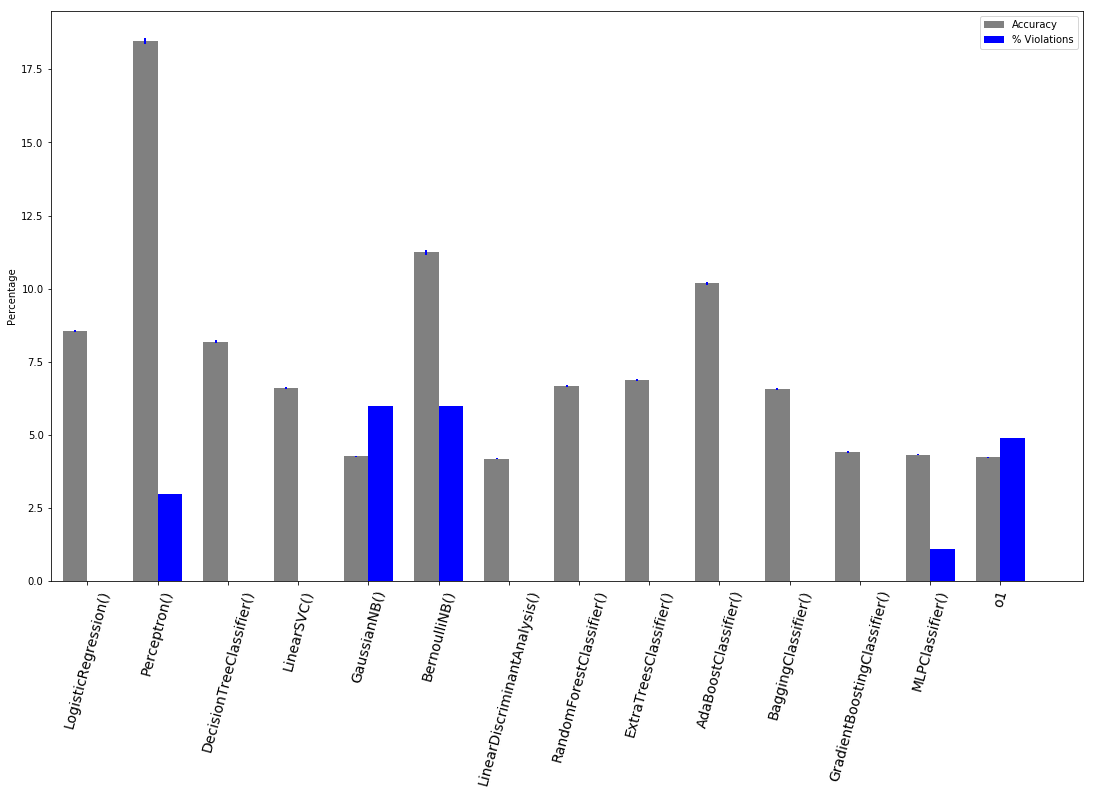

In [7]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))

LogisticRegression()
Area under surface (rectangular approx) =  2838.96295
Violations =  0.0
Average_violations =  0.0
MSE =  8.567963333333333


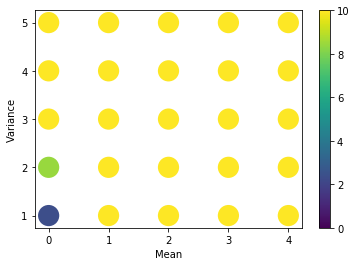

Perceptron()
Area under surface (rectangular approx) =  3478.8386499999997
Violations =  10.0
Average_violations =  3.0
MSE =  18.465178333333334


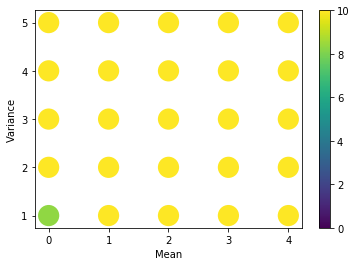

DecisionTreeClassifier()
Area under surface (rectangular approx) =  1297.4452166666667
Violations =  0.0
Average_violations =  0.0
MSE =  8.188898333333334


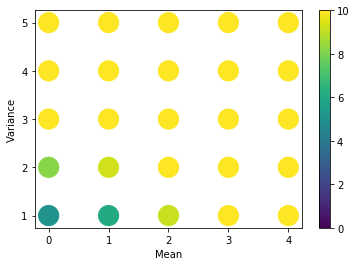

LinearSVC()
Area under surface (rectangular approx) =  2245.2653333333333
Violations =  0.0
Average_violations =  0.0
MSE =  6.603105000000001


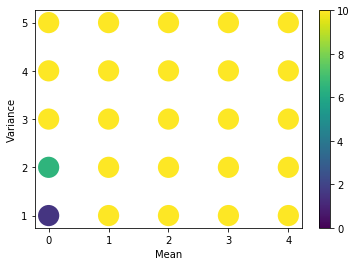

GaussianNB()
Area under surface (rectangular approx) =  1038.0088833333332
Violations =  10.0
Average_violations =  6.0
MSE =  4.272321666666667


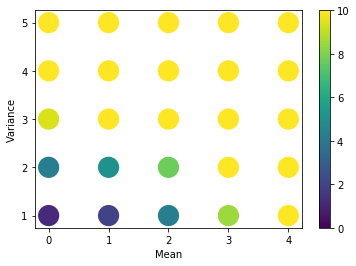

BernoulliNB()
Area under surface (rectangular approx) =  6290.37075
Violations =  10.0
Average_violations =  6.0
MSE =  11.239685


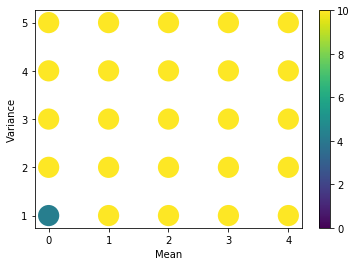

LinearDiscriminantAnalysis()
Area under surface (rectangular approx) =  949.8255833333335
Violations =  0.0
Average_violations =  0.0
MSE =  4.186468333333333


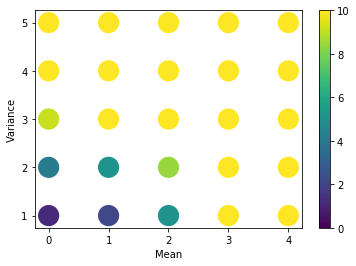

RandomForestClassifier()
Area under surface (rectangular approx) =  1826.79045
Violations =  0.0
Average_violations =  0.0
MSE =  6.6660699999999995


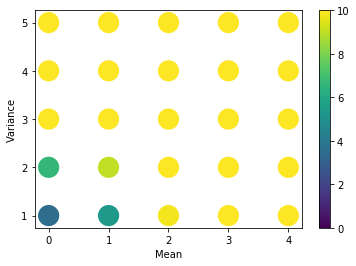

ExtraTreesClassifier()
Area under surface (rectangular approx) =  1655.3324166666664
Violations =  0.0
Average_violations =  0.0
MSE =  6.880086666666666


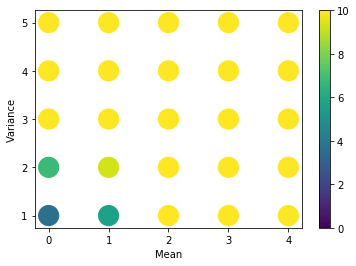

AdaBoostClassifier()
Area under surface (rectangular approx) =  4559.90315
Violations =  0.0
Average_violations =  0.0
MSE =  10.184508333333333


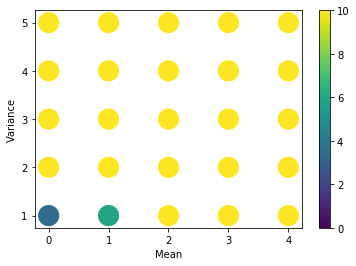

BaggingClassifier()
Area under surface (rectangular approx) =  1225.3826666666666
Violations =  0.0
Average_violations =  0.0
MSE =  6.582755000000001


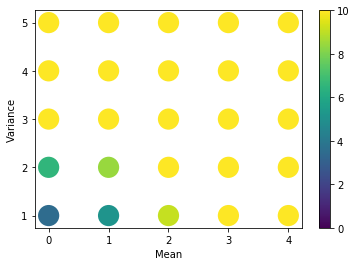

GradientBoostingClassifier()
Area under surface (rectangular approx) =  1197.4311
Violations =  0.0
Average_violations =  0.0
MSE =  4.412471666666667


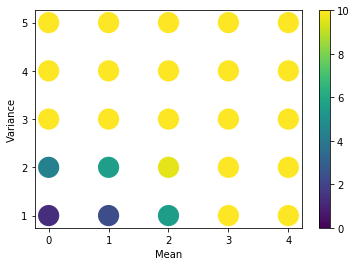

MLPClassifier()
Area under surface (rectangular approx) =  1245.4464666666668
Violations =  10.0
Average_violations =  1.1
MSE =  4.32152


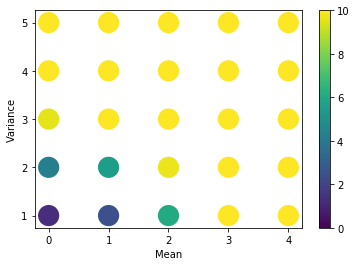

o1
Area under surface (rectangular approx) =  442.2595301101473
Violations =  10.0
Average_violations =  4.9
MSE =  4.240801713162045


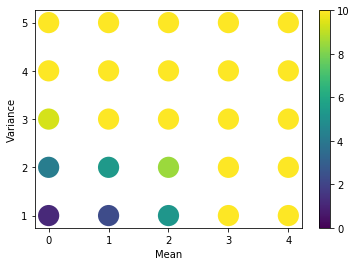

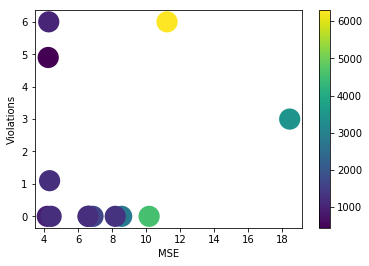

In [8]:
def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    
#for idx, m in enumerate(models):
#    print(model_names[idx])      
#    x = []
#    y = []
#    z = []
#    for k, v in causal_dicts[idx].items():
#        x.append(k.split('_')[0])
#        y.append(k.split('_')[-1])
#        z.append(np.sum(v) / len(v))
#    print("Causal assurance")
#    heat_plot(x,y,z, clim_low = 0, clim_high = 1) 

1912.5850639265632 167.38439294309202


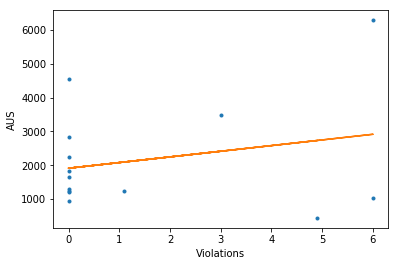

7.1496331622065545 0.22461757661604548


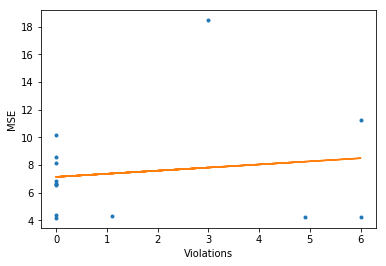

3.5558865878826826 288.5311682790056


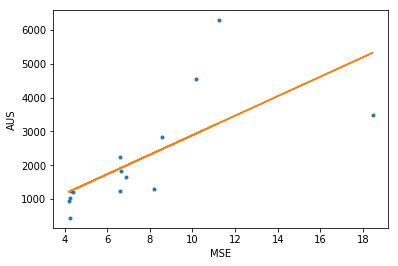

In [10]:
from numpy.polynomial.polynomial import polyfit  
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
print(b,m)
ax.plot(VIO,AUS, '.')

plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("AUS")
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')

plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
print(b,m)
ax.plot(MSE, AUS, '.')

plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()